##### ARTI 560 - Computer Vision  
## Image Classification using Transfer Learning - Exercise

### Objective

In this exercise, you will:

1. Select another pretrained model (e.g., VGG16, MobileNetV2, or EfficientNet) and fine-tune it for CIFAR-10 classification.  
You'll find the pretrained models in [Tensorflow Keras Applications Module](https://www.tensorflow.org/api_docs/python/tf/keras/applications).




In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

2. Before training, inspect the architecture using model.summary() and observe:
- Network depth
- Number of parameters
- Trainable vs Frozen layers




In [20]:

# -----------------------------
# 1) Load CIFAR-10
# -----------------------------
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

class_names = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

# Keep labels as integers (SparseCategoricalCrossentropy)
y_train = y_train.squeeze().astype("int64")
y_test  = y_test.squeeze().astype("int64")

# Convert images to float32
x_train = x_train.astype("float32")
x_test  = x_test.astype("float32")

In [21]:
# -----------------------------
# 2) Data augmentation
# -----------------------------
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augmentation")


In [22]:
# -----------------------------
# 3) Build EfficientNetB0 backbone (pretrained) without classifier layer.
# -----------------------------
efficientnet_base = keras.applications.EfficientNetB0(
    include_top=False,  # Exclude classifier layer for transfer learning
    weights="imagenet",
    input_shape=(96, 96, 3)  # Reduce input size to save memory
)

efficientnet_base.trainable = True  # Unfreeze for fine-tuning
for layer in efficientnet_base.layers[:-30]:
    layer.trainable = False

print("Trainable layers in backbone:", sum(l.trainable for l in efficientnet_base.layers), "/", len(efficientnet_base.layers))

Trainable layers in backbone: 30 / 238


In [23]:
# -----------------------------
# 4) Full model (preprocess inside model)
# -----------------------------
efficientnet_model = keras.Sequential([
    layers.Input(shape=(32, 32, 3)),
    data_augmentation,
    layers.Resizing(96, 96, interpolation="bilinear"),  # Match EfficientNetB0 input
    layers.Lambda(preprocess_input),
    efficientnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(10)  # logits
], name="cifar10_efficientnetb0")

efficientnet_model.summary()

Model: "cifar10_efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_2 (Resizing)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 1,508,970 (5.76 MB)

 Non-trainable params: 2,553,411 (9.74 MB)

In [24]:

# -----------------------------
# 5) Compile + Train (frozen backbone)
# -----------------------------
efficientnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1),
]





In [25]:
history = efficientnet_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=34,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/5
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 96s 62ms/step - accuracy: 0.7372 - loss: 0.7685 - val_accuracy: 0.8852 - val_loss: 0.3339 - learning_rate: 0.0010
Epoch 2/5
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 78s 59ms/step - accuracy: 0.8456 - loss: 0.4499 - val_accuracy: 0.8940 - val_loss: 0.3182 - learning_rate: 0.0010
Epoch 3/5
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 77s 58ms/step - accuracy: 0.8652 - loss: 0.3821 - val_accuracy: 0.8978 - val_loss: 0.3077 - learning_rate: 0.0010
Epoch 4/5
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 76s 58ms/step - accuracy: 0.8826 - loss: 0.3335 - val_accuracy: 0.9012 - val_loss: 0.3248 - learning_rate: 0.0010
Epoch 5/5
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 76s 57ms/step - accuracy: 0.9062 - loss: 0.2668 - val_accuracy: 0.9134 - val_loss: 0.2634 - learning_rate: 5.0000e-04


In [26]:
test_loss_ft, test_acc_ft = efficientnet_model.evaluate(x_test, y_test, verbose=0)
print("EfficientNetB0 (fine-tuned) test accuracy:", test_acc_ft)
print("EfficientNetB0 (fine-tuned) test loss    :", test_loss_ft)

EfficientNetB0 (fine-tuned) test accuracy: 0.9154000282287598
EfficientNetB0 (fine-tuned) test loss    : 0.26005929708480835


3. Then compare its performance with ResNet and the custom CNN.


- <span style = 'color:pink'>As shown in the code above, EfficirentNetB0 were faster comapring it to resnet but slower than CNN 
Also, it scored greater accuracy Than CNN while coring close but lesser accuracy comparing it to ResNet50V2

- <span style = 'color:pink'>CNN were the fastest to train but has scored the lowest accuracy as shown in the image:
![Screenshot 2026-02-16 182044.png](<attachment:Screenshot 2026-02-16 182044.png>)
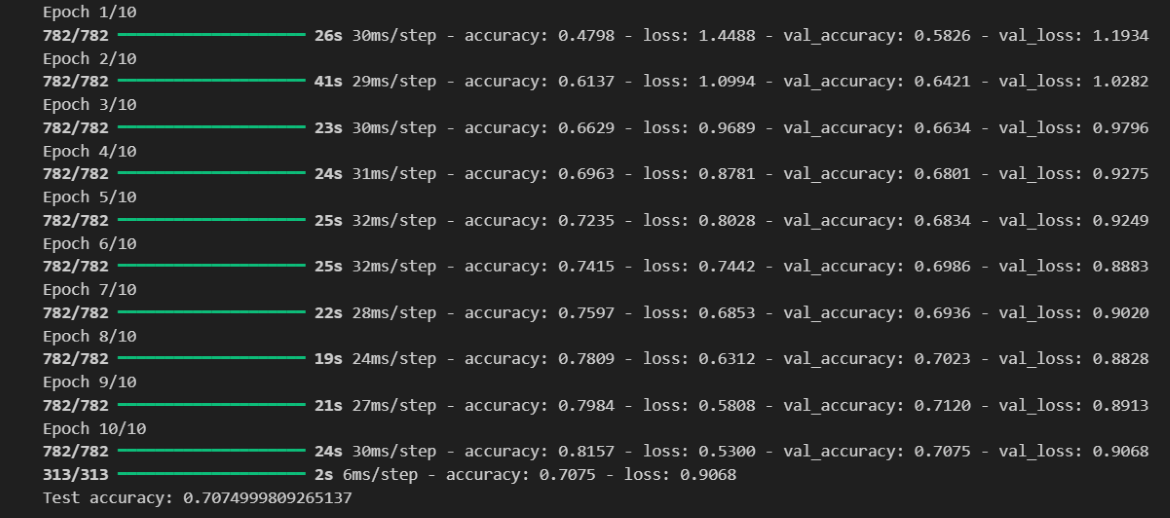

 - <span style = 'color:pink'> ResNet50V2 were the slowest to train but scored the highest accuracy among other models as shown in the image: </span>
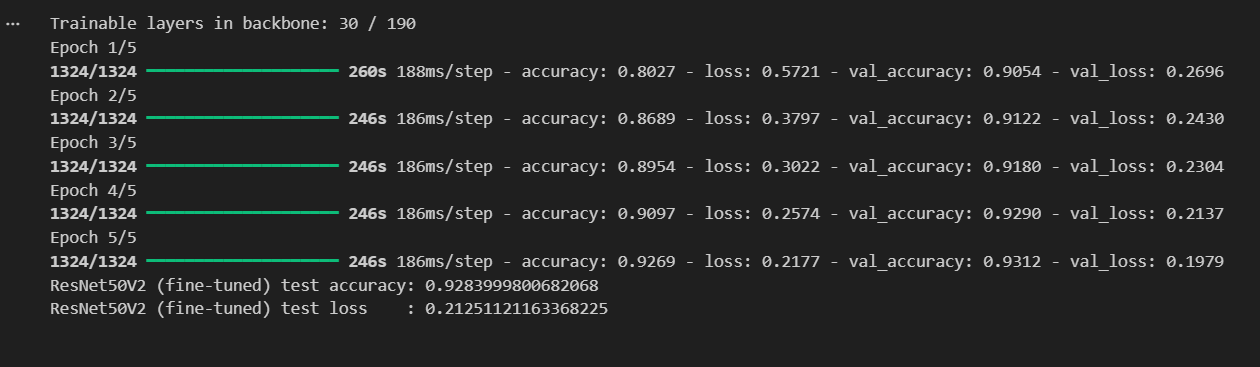


### Questions:

- Which model achieved the highest accuracy? <span style = 'color :pink'> ResNet50V5 </span>
- Which model trained faster? <span style = 'color :pink'> The custom CNN </span>
- How might the architecture explain the differences? <span style = 'color: pink'>the deeper the depth of the model the highest the accuracy will be ,but it will slow the training time </span>